<a href="https://colab.research.google.com/github/irythmgarg/TOPSIS-ON-PRETRAINED-MODELS/blob/main/Topsis_On_Pretrained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Topsis On Pretrained Model for text Conversational***

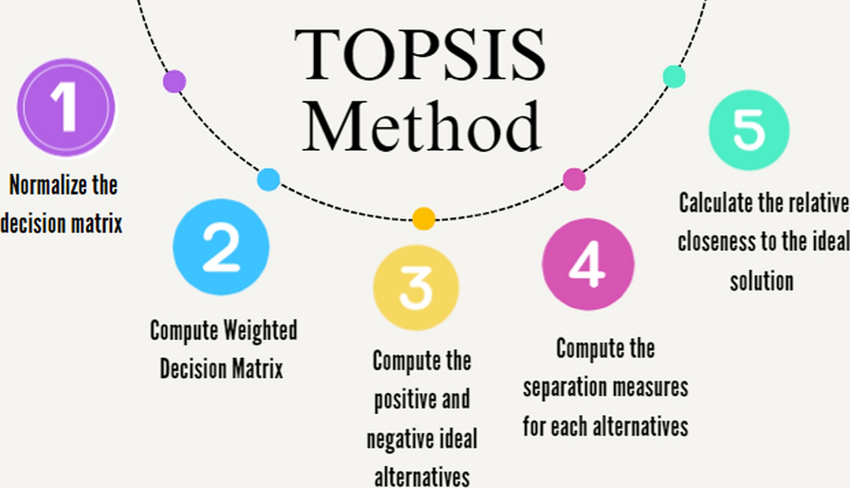

In [41]:
from IPython.display import Image
# Display the image
Image('/content/Five-different-phases-of-TOPSIS-method.png')

In [11]:
!pip install transformers
!pip install topsis
!pip install transformers numpy scikit-learn textstat vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.2 MB/s eta 0:00:00


In [5]:
!pip install transformers numpy scikit-learn

In [42]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import textstat
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
# Define models for comparison
models = {
    "bert": "bert-base-uncased",
    "roberta": "roberta-base",
    "distilbert": "distilbert-base-uncased"
}

In [36]:
# Sample input texts
texts = [
    "Artificial intelligence is transforming the world.",
    "Deep learning models require large datasets.",
    "Transformers have revolutionized NLP."
]


In [37]:
# Initialize tokenizer, model, and additional metrics
def get_model_outputs(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    text_lengths = []
    readability_scores = []
    sentiment_scores = []

    sentiment_analyzer = SentimentIntensityAnalyzer()

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the CLS token representation as the sentence embedding
        embedding = outputs.last_hidden_state[:, 0, :].mean().item()
        embeddings.append(embedding)

        # Compute additional features
        text_lengths.append(len(text))
        readability_scores.append(textstat.flesch_reading_ease(text))
        sentiment_scores.append(sentiment_analyzer.polarity_scores(text)['compound'])

    # Compute average of each feature for the model
    return {
        "embedding": np.mean(embeddings),
        "text_length": np.mean(text_lengths),
        "readability": np.mean(readability_scores),
        "sentiment": np.mean(sentiment_scores)
    }

In [38]:
# Collect feature values for each model
decision_matrix = []
for model_name, model_path in models.items():
    metrics = get_model_outputs(model_path)
    decision_matrix.append([metrics["embedding"], metrics["text_length"], metrics["readability"], metrics["sentiment"]])

decision_matrix = np.array(decision_matrix)
print("Decision Matrix:\n", decision_matrix)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decision Matrix:
 [[-1.19327555e-02  4.36666667e+01  9.66333333e+00  1.58900000e-01]
 [ 2.08721633e-02  4.36666667e+01  9.66333333e+00  1.58900000e-01]
 [-9.29104288e-03  4.36666667e+01  9.66333333e+00  1.58900000e-01]]


In [39]:
normalized_matrix = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))

# Step 2: Determine Ideal Best and Ideal Worst
ideal_best = np.max(normalized_matrix, axis=0)  # Higher is better for all criteria
ideal_worst = np.min(normalized_matrix, axis=0)

# Step 3: Compute Euclidean Distance from Ideal Best and Worst
distance_best = np.sqrt(((normalized_matrix - ideal_best) ** 2).sum(axis=1))
distance_worst = np.sqrt(((normalized_matrix - ideal_worst) ** 2).sum(axis=1))

# Step 4: Compute TOPSIS Score
topsis_scores = distance_worst / (distance_best + distance_worst)

# Rank the models
rankings = np.argsort(-topsis_scores)  # Sort in descending order

# Print final rankings
print("\nTOPSIS Scores:")
for i, model_name in enumerate(models.keys()):
    print(f"{model_name}: {topsis_scores[i]:.4f}")



TOPSIS Scores:
bert: 0.0000
roberta: 1.0000
distilbert: 0.0805


In [40]:
print("\nFinal Ranking (Best to Worst):")
sorted_models = [list(models.keys())[i] for i in rankings]
for rank, model in enumerate(sorted_models):
    print(f"{rank + 1}. {model} (Score: {topsis_scores[rank]:.4f})")

# Best Model
best_model = sorted_models[0]
print(f"\n🏆 Best Model Based on TOPSIS: {best_model}")


Final Ranking (Best to Worst):
1. roberta (Score: 0.0000)
2. distilbert (Score: 1.0000)
3. bert (Score: 0.0805)

🏆 Best Model Based on TOPSIS: roberta



TOPSIS Scores:
bert: 0.0000
roberta: 1.0000
distilbert: 0.0805

Final Ranking (Best to Worst):
1. roberta (Score: 0.0000)
2. distilbert (Score: 1.0000)
3. bert (Score: 0.0805)

🏆 Best Model Based on TOPSIS: roberta


<ipython-input-43-f709065140d9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.keys()), y=topsis_scores, palette="viridis")


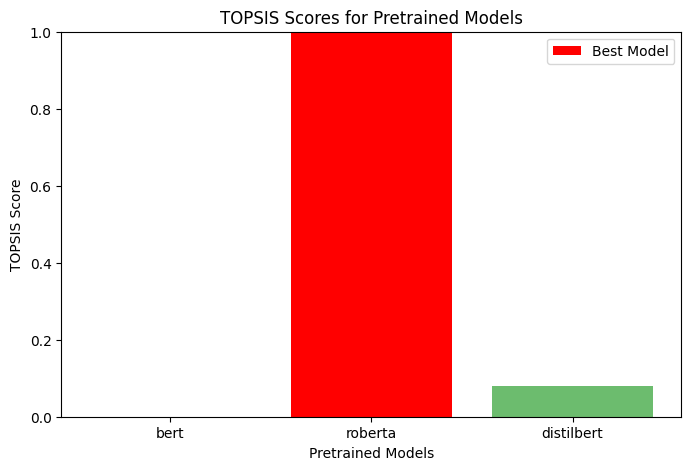

In [43]:
# Print final rankings
print("\nTOPSIS Scores:")
for i, model_name in enumerate(models.keys()):
    print(f"{model_name}: {topsis_scores[i]:.4f}")

print("\nFinal Ranking (Best to Worst):")
sorted_models = [list(models.keys())[i] for i in rankings]
for rank, model in enumerate(sorted_models):
    print(f"{rank + 1}. {model} (Score: {topsis_scores[rank]:.4f})")

# Best Model
best_model = sorted_models[0]
print(f"\n🏆 Best Model Based on TOPSIS: {best_model}")

# Plot TOPSIS Scores
plt.figure(figsize=(8, 5))
sns.barplot(x=list(models.keys()), y=topsis_scores, palette="viridis")
plt.xlabel("Pretrained Models")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Scores for Pretrained Models")
plt.ylim(0, 1)

# Highlight the best model
best_index = list(models.keys()).index(best_model)
plt.bar(best_index, topsis_scores[best_index], color='red', label="Best Model")
plt.legend()
plt.show()